What this notebook does:

Compares different methods of assigning sentiment to the 5 LDA topics for each review sentence. The features corresponding to different methods of sentiment->topic assignment are stored in './LDA_5topic_SentimentAssignment/comparingthresholds_reviewsent.csv'.  Features are compared on their ability to predict review rating (after averaging topic sentiment across the sentences of each review).

For each sentence (row) in the 'comparingthresholds_reviewsent.csv' file, a compound sentiment score and a set of topic importance scores were calculated. Sentiment were asssigned to a topic based on that topic's importance score. Too low a score threshold, and sentiment gets assigned to irrelevant topics (that the user isn't even discussing). Too high a score threshold, and no topics get assigned sentiment. Additionally the entire sentiment('hard'), or sentiment x topic_importance ('soft') were assigned to the corresponding sentiment.  Each column of the table corresponds to a different combination of threshold, topic, and 'hard vs soft'.

To compare different procedures for assigning sentiment to topics, I use the metric of test accuracy in predicting the rating for reviews. Assuming topic specific sentiments are predictive of review rating, I expect procedures that lead to noisy or biased estimates of topic sentiment to degrade predictive performance. 

To predict review rating from the features being considered, I used a random forest regression model. The main reason behind this choice was to account for the non-linear relationship between Yelp review rating, and sentiment (There is no review higher than 5 or lower than 1).

Random forest models containing feature sets were compared:
    1) the union of all possible combinations of (topic, importance_threshold, hard_vs_soft),whole review sentiment, and whole review topic importance.
    2) the union of all possible combinations of (topic, importance_threshold, hard_vs_soft),whole review sentiment, whole review topic importances, and whole review sentiment weighted by topic importances.
    3) Whole review sentiment, whole review topic importances, whole review sentiment weighted by topic importances
    4) Whole review sentiment, whole review topic importances, topic sentiments (based on threshold 0.2 and 'soft' assignment of sentiment to topics)
    5) Whole review sentiment, whole review topic importances, topic sentiments (based on threshold 0.4 and 'soft' assignment of sentiment to topics)
    6) Whole review sentiment, whole review topic importances, topic sentiments (based on threshold 0.6 and 'soft' assignment of sentiment to topics)
    8) Whole review sentiment, whole review topic importances, topic sentiments (based on threshold 0.4 and 'hard' assignment of sentiment to topics)
    
Use of theshold 0.2, and proportional('soft') assignment of sentence sentiment to topics, resulted in slightly better predictive performance. The corresponding features are calculated for all sentences for all reviews, and used to obtain a topic sentiment for each review.

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import nlp_helpers

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import pickle
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora


In [42]:
sentdf = pd.read_csv('./sentiment_sentence_ldaassignment/comparingthresholds_reviewsent.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
reviews = reviews.dropna(axis=0)

In [43]:
#Loading the previously trained LDA model

dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

In [44]:
ldavecs = nlp_helpers.getldavec(reviews.review_lem_noun.tolist(),dictionary,lda)

In [45]:
#get vader sentiment for each review 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vs = [analyzer.polarity_scores(txt)['compound'] for txt in reviews.reviewtxt.to_list()]


In [46]:
topicweightedsent = [[component*sent for component in vec] for (vec,sent) in zip(ldavecs,vs)]

In [47]:

reviews.reset_index(inplace=True, drop = True)
ldavecdf = pd.DataFrame(ldavecs)
ldavecdf.columns = ['t0','t1','t2','t3','t4']
ldavecdf.fillna(value = 0,inplace=True)

topicwsentdf = pd.DataFrame(topicweightedsent)
topicwsentdf.columns = ['t0s_wholerev','t1s_wholerev','t2s_wholerev','t3s_wholerev','t4s_wholerev']
topicwsentdf.fillna(value=0, inplace=True)


reviews = pd.concat([reviews,ldavecdf,topicwsentdf],axis=1)
reviews['vs'] = pd.Series(vs)
reviews['reviewlen'] = reviews['mreviewtxt'].str.len()

In [48]:
reviews.head(5)

,reviewidx,shopidx,alias,date,revrating,reviewtxt,mreviewtxt,review_lem_noun,review_lem_nounverb,review_lem_nounadj,...,t2,t3,t4,t0s_wholerev,t1s_wholerev,t2s_wholerev,t3s_wholerev,t4s_wholerev,vs,reviewlen
0,6,0,little-canal-new-york-2,2019-12-21,3.0,It was my first time to the Little Canal. I w...,it was my first time to the little canal. i w...,time canal review person oat latte way catch f...,time canal look ice decide come see review per...,first time little canal positive review interi...,...,0.269288,0.019133,0.019149,0.301664,0.340980,0.249926,0.017757,0.017772,0.9281,458
1,7,0,little-canal-new-york-2,2019-12-19,5.0,Just moved to the area and although there are ...,just moved to the area and although there are ...,cafe neighborhood spot job staff vibe anxiety ...,move cafe choose stop work feel neighborhood s...,many cafe favorite friendly neighborhood spot ...,...,0.278795,0.172469,0.011133,0.262258,0.254110,0.267782,0.165656,0.010693,0.9605,751
2,8,0,little-canal-new-york-2,2019-12-14,5.0,"Daytime: cafe. Nighttime: chillest, coziest ba...",daytime: cafe. nighttime: chillest coziest ba...,nighttime bar vibe vibe price bank table wait ...,nighttime bar could want come vibe stay vibe p...,nighttime cozy bar vibe vibe price bank weekni...,...,0.238303,0.117720,0.011884,0.011603,0.602728,0.231607,0.114412,0.011550,0.9719,478
3,9,0,little-canal-new-york-2,2019-11-04,4.0,I always end up in here after I go to the Metr...,i always end up in here after i go to the metr...,spritz commissary canal hip atmosphere pretens...,want spend spritz commissary canal chill hip a...,spritz commissary little canal hip atmosphere ...,...,0.079134,0.000000,0.000000,0.142463,0.754150,0.077773,0.000000,0.000000,0.9828,1427
4,10,0,little-canal-new-york-2,2019-10-26,5.0,Stopped here Sunday 10/11/19 late in the day a...,stopped here sunday / / late in the day afte...,gallery beer hummus sandwich day sort way service,stop gallery open beer hummus sandwich would e...,gallery nearby fantastic beer hummus sandwich ...,...,0.443779,0.307111,0.022434,0.019255,0.175141,0.380585,0.263379,0.019240,0.8576,272


In [49]:
#Grouping sentences by review and averaging the thresholded lda sentiment scores
#Only take the average of non-zero sentiment scores for each topic.
#If a topic isn't discussed that should not bring down the average sentiment score for that topic.
#sentdf.fillna(value = 0,inplace=True)
review_avgsentiment = sentdf.drop(['sentence','lemsentence'],axis=1).groupby(['reviewidx']).mean()
review_avgsentiment.reset_index(inplace=True)

#At the higher thresholds for assigning sentences to topic (0.8) as much as 90% of reviews in the dataset have an
#unknown sentiment for the coffee shop topic
print(review_avgsentiment.describe())

#Fill the nans with 0. Topic sentiments that are unknown should be set to 0. If a topic didn't come up in a review
#the sentiment with respect to that topic should be neutral.
#Alternatively, if failure to mention a topic actually corresponds to slightly 

review_avgsentiment.fillna(value=0,inplace=True)
print(review_avgsentiment.describe())

print(review_avgsentiment.head(5))
print(review_avgsentiment.shape)
print(reviews[reviews.isnull().any(axis=1)])

         reviewidx           vs  t0s_0.2_soft  t1s_0.2_soft  t2s_0.2_soft  \
count   5000.00000  5000.000000   4517.000000   4032.000000   3931.000000   
mean   27210.89220     0.280040      0.137999      0.127834      0.065731   
std    17065.44638     0.324883      0.167887      0.160085      0.164056   
min       11.00000    -0.953300     -0.528501     -0.601216     -0.825713   
25%    13071.75000     0.072186      0.015221      0.000000     -0.012243   
50%    25862.50000     0.297908      0.140751      0.127359      0.064233   
75%    39709.25000     0.496100      0.240342      0.226441      0.170903   
max    83010.00000     0.995300      0.865313      0.776717      0.698494   

       t3s_0.2_soft  t4s_0.2_soft  t0s_0.2_hard  t1s_0.2_hard  t2s_0.2_hard  \
count   3233.000000   3363.000000   4517.000000   4032.000000   3931.000000   
mean       0.125400      0.105516      0.304288      0.303949      0.191396   
std        0.150990      0.153720      0.354843      0.355544      0.

In [50]:
wholerevsentiment = ['t' + str(i) + 's_wholerev' for i in range(5)]
columnstokeep = ['reviewidx','revrating','t0','t1','t2','t3','t4','vs','reviewlen']
columnstokeep.extend(wholerevsentiment)
reviews = reviews[columnstokeep]
combined_avg = reviews.merge(review_avgsentiment.drop(['vs'],axis=1),how='inner',left_on='reviewidx', right_on='reviewidx')


In [51]:
X = combined_avg.drop(['reviewidx','revrating'],axis=1)
print(X.columns)
y = combined_avg['revrating']

Index(['t0', 't1', 't2', 't3', 't4', 'vs', 'reviewlen', 't0s_wholerev',
       't1s_wholerev', 't2s_wholerev', 't3s_wholerev', 't4s_wholerev',
       't0s_0.2_soft', 't1s_0.2_soft', 't2s_0.2_soft', 't3s_0.2_soft',
       't4s_0.2_soft', 't0s_0.2_hard', 't1s_0.2_hard', 't2s_0.2_hard',
       't3s_0.2_hard', 't4s_0.2_hard', 't0s_0.4_soft', 't1s_0.4_soft',
       't2s_0.4_soft', 't3s_0.4_soft', 't4s_0.4_soft', 't0s_0.4_hard',
       't1s_0.4_hard', 't2s_0.4_hard', 't3s_0.4_hard', 't4s_0.4_hard',
       't0s_0.6_soft', 't1s_0.6_soft', 't2s_0.6_soft', 't3s_0.6_soft',
       't4s_0.6_soft', 't0s_0.6_hard', 't1s_0.6_hard', 't2s_0.6_hard',
       't3s_0.6_hard', 't4s_0.6_hard', 't0s_0.8_soft', 't1s_0.8_soft',
       't2s_0.8_soft', 't3s_0.8_soft', 't4s_0.8_soft', 't0s_0.8_hard',
       't1s_0.8_hard', 't2s_0.8_hard', 't3s_0.8_hard', 't4s_0.8_hard'],
      dtype='object')


In [52]:
#Splitting the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape
y_train.shape


(3341,)

In [53]:
#A linear model is not very appropriate since values are confined between 0 and 5
#Will use the random forest instead and look at random forest importances.
#Use random forest regression since there is an ordering to the yelp ratings. 4 is closer to 5 than 1.

from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30,40]
max_features = ['auto','sqrt']

results = []
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train.drop(wholerevsentiment,axis=1),y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']

print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)


OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.4561965001108207]
[100, 1, 'sqrt', 0.3703762990163081]
[100, 10, 'auto', 0.5993928206429395]
[100, 10, 'sqrt', 0.5926505942953257]
[100, 20, 'auto', 0.5894572518384025]
[100, 20, 'sqrt', 0.5852372222034161]
[100, 30, 'auto', 0.5880430664769731]
[100, 30, 'sqrt', 0.5871367619120774]
[100, 40, 'auto', 0.5871469477278635]
[100, 40, 'sqrt', 0.5905150202084638]
[200, 1, 'auto', 0.45518544313574916]
[200, 1, 'sqrt', 0.3837708857182772]
[200, 10, 'auto', 0.5990516022694647]
[200, 10, 'sqrt', 0.6012484908155189]
[200, 20, 'auto', 0.594780479441031]
[200, 20, 'sqrt', 0.599798954959845]
[200, 30, 'auto', 0.597355533106737]
[200, 30, 'sqrt', 0.5971243664205479]
[200, 40, 'auto', 0.5970595650329548]
[200, 40, 'sqrt', 0.5980227704859631]
[500, 1, 'auto', 0.456330570547534]
[500, 1, 'sqrt', 0.378028937251213]
[500, 10, 'auto', 0.6025745564102987]
[500, 10, 'sqrt', 0.6005240639761504]
[500, 20, 'auto', 0.5985068096942953]
[500, 20, 'sqrt'

         feature  importance
5             vs    0.182441
14  t2s_0.2_hard    0.082023
9   t2s_0.2_soft    0.080542
12  t0s_0.2_hard    0.066362
7   t0s_0.2_soft    0.062534
19  t2s_0.4_soft    0.052590
24  t2s_0.4_hard    0.046191
13  t1s_0.2_hard    0.043233
8   t1s_0.2_soft    0.040914
11  t4s_0.2_soft    0.031747
16  t4s_0.2_hard    0.027565
2             t2    0.026069
15  t3s_0.2_hard    0.024634
10  t3s_0.2_soft    0.021728
34  t2s_0.6_hard    0.020424
29  t2s_0.6_soft    0.019836
17  t0s_0.4_soft    0.017516
6      reviewlen    0.016967
22  t0s_0.4_hard    0.016250
0             t0    0.013848
0.7260602337509517
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14521204675019034


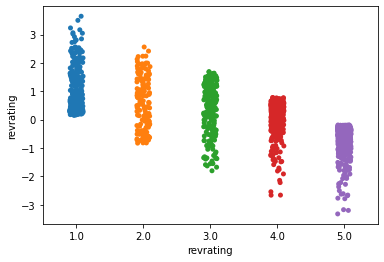

In [72]:
model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,max_features = 'sqrt',oob_score=True).fit(X_train.drop(wholerevsentiment,axis=1),y_train)

toplot = pd.DataFrame([i for i in zip(X_train.drop(wholerevsentiment,axis=1).columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(20))

ypred = model.predict(X_test.drop(wholerevsentiment,axis=1))
sns.stripplot(y_test,ypred-y_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)


The fitted random forest model tends to over predict the rating for poorly rated shops, and underpredict for highly rated shops. The topic importances are such that using high topic importance cutoffs of 0.6, 0.8 yield features that are of low importance in the random forest regressor, while using low cutoffs of 0.2 and 0.4 yield features with higher importance in the random forest. In terms of the topics, whose sentiments have the greatest importance, the 'lines', and 'coffee shop' topic are at 0.06-0.07, followed by ambience at 0.04, sweets at 0.030, and food at 0.02. Overal review sentiment has the greatest topic importance at 0.15.

Now including sentiments that are derived from the whole-review topic importances, together with the sentiment scores derived from sentence level topic importances/sentiments


In [55]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train,y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)


OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.4573396555242504]
[100, 1, 'sqrt', 0.44716523187365464]
[100, 10, 'auto', 0.5948063188898235]
[100, 10, 'sqrt', 0.597343886536787]
[100, 20, 'auto', 0.5811879414762512]
[100, 20, 'sqrt', 0.5989982355870112]
[100, 30, 'auto', 0.5849070376939631]
[100, 30, 'sqrt', 0.5970062715438222]
[200, 1, 'auto', 0.45867632965846605]
[200, 1, 'sqrt', 0.46070480335397035]
[200, 10, 'auto', 0.6021116736284621]
[200, 10, 'sqrt', 0.6030829127576282]
[200, 20, 'auto', 0.5951216030451855]
[200, 20, 'sqrt', 0.6003491419388995]
[200, 30, 'auto', 0.593799855837781]
[200, 30, 'sqrt', 0.6068351479613425]
[500, 1, 'auto', 0.4586405950104163]
[500, 1, 'sqrt', 0.4612382096831057]
[500, 10, 'auto', 0.606320904990947]
[500, 10, 'sqrt', 0.6051450025561473]
[500, 20, 'auto', 0.5994961608994451]
[500, 20, 'sqrt', 0.6027370263840504]
[500, 30, 'auto', 0.5984589740420299]
[500, 30, 'sqrt', 0.6034202546043805]


         feature  importance
5             vs    0.139609
7   t0s_wholerev    0.097986
8   t1s_wholerev    0.094279
9   t2s_wholerev    0.075900
10  t3s_wholerev    0.063014
11  t4s_wholerev    0.048100
14  t2s_0.2_soft    0.043865
19  t2s_0.2_hard    0.041385
17  t0s_0.2_hard    0.038611
12  t0s_0.2_soft    0.033334
24  t2s_0.4_soft    0.026758
18  t1s_0.2_hard    0.026369
29  t2s_0.4_hard    0.023264
13  t1s_0.2_soft    0.022962
2             t2    0.019706
6      reviewlen    0.018047
16  t4s_0.2_soft    0.016700
20  t3s_0.2_hard    0.014918
21  t4s_0.2_hard    0.014302
15  t3s_0.2_soft    0.012771
0.7199802812254367
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14399605624508732


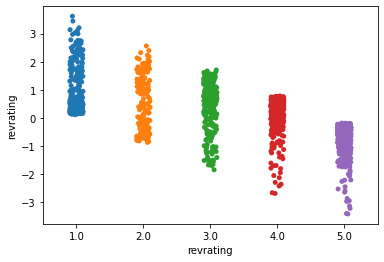

In [71]:
model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,max_features = 'sqrt',oob_score=True).fit(X_train,y_train)

toplot = pd.DataFrame([i for i in zip(X_train.columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(20))

ypred = model.predict(X_test)
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)

In [57]:
preddf = pd.DataFrame([i for i in zip(ypred,y_test)])
preddf.columns = ['ypred','ytest']
print('mean prediction for different true ratings')
print(preddf.groupby(['ytest']).mean())
print('variance in predictions for different true ratings')
print(preddf.groupby(['ytest']).var())


mean prediction for different true ratings
          ypred
ytest          
1.0    2.012523
2.0    2.613658
3.0    3.353039
4.0    4.100533
5.0    4.346344
variance in predictions for different true ratings
          ypred
ytest          
1.0    0.712325
2.0    0.874622
3.0    0.853826
4.0    0.364430
5.0    0.225476


In [58]:
#Random forest only on whole review topic importance, whole review sentiment (no sentence derived sentiment score)
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_wholerev','t1s_wholerev','t2s_wholerev','t3s_wholerev','t4s_wholerev']
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train[wholerevfeat],y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)


OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.458689878542047]
[100, 1, 'sqrt', 0.4658776152740911]
[100, 10, 'auto', 0.5455116512779175]
[100, 10, 'sqrt', 0.5578719765307176]
[100, 20, 'auto', 0.5311247255076259]
[100, 20, 'sqrt', 0.5360169234058261]
[100, 30, 'auto', 0.5312356461408999]
[100, 30, 'sqrt', 0.5333110855323147]
[200, 1, 'auto', 0.4582156852875915]
[200, 1, 'sqrt', 0.4702896117972284]
[200, 10, 'auto', 0.5511688579052951]
[200, 10, 'sqrt', 0.5620556482503305]
[200, 20, 'auto', 0.536241134770424]
[200, 20, 'sqrt', 0.5442267287020529]
[200, 30, 'auto', 0.5381897045046531]
[200, 30, 'sqrt', 0.5439380509143341]
[500, 1, 'auto', 0.45793962195503457]
[500, 1, 'sqrt', 0.46777187348654425]
[500, 10, 'auto', 0.5529149411148041]
[500, 10, 'sqrt', 0.5633097311869782]
[500, 20, 'auto', 0.5433892946898315]
[500, 20, 'sqrt', 0.5474754152562545]
[500, 30, 'auto', 0.5399055491308941]
[500, 30, 'sqrt', 0.5485376829466967]


         feature  importance
5             vs    0.249766
8   t1s_wholerev    0.153179
7   t0s_wholerev    0.144671
9   t2s_wholerev    0.108572
10  t3s_wholerev    0.077961
11  t4s_wholerev    0.059012
6      reviewlen    0.056038
2             t2    0.047953
0             t0    0.029924
1             t1    0.026589
3             t3    0.023934
4             t4    0.022401
0.7417529921933191
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14835059843866383


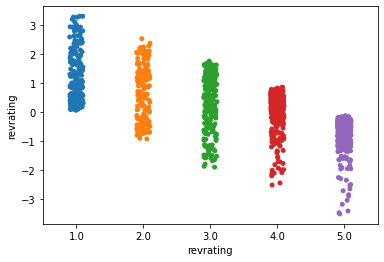

In [70]:
from sklearn.metrics import mean_absolute_error
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_wholerev','t1s_wholerev','t2s_wholerev','t3s_wholerev','t4s_wholerev']


model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,
                              max_features = 'sqrt',oob_score=True).fit(X_train[wholerevfeat],y_train)

toplot = pd.DataFrame([i for i in zip(X_train.columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(50))

ypred = model.predict(X_test[wholerevfeat])
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)


Using only whole-review attributes (topic sentiments and importances), mean percent test error is slightly worse (15% vs 14.6%). Therefore the additional sentence derived topic sentiments help improve the ability of the random forest to predict review rating. However, the higher feature importance of the whole-review-topic-sentiments make it a better metric to use to compute average topic sentiments for restaurants.  I use display these topic sentiment scores for the dashborad.

Using only the sentiment features derived with threshold 0.2 and soft thresholding.

In [62]:
#Random forest only on whole review topic importance, whole review sentiment (no sentence derived sentiment score)
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.2_soft','t1s_0.2_soft','t2s_0.2_soft','t3s_0.2_soft','t4s_0.2_soft']
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train[wholerevfeat],y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)


OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.4555680663570748]
[100, 1, 'sqrt', 0.41524118744670224]
[100, 10, 'auto', 0.5926940057086884]
[100, 10, 'sqrt', 0.6047956149758961]
[100, 20, 'auto', 0.5888871674289657]
[100, 20, 'sqrt', 0.5944040513446933]
[100, 30, 'auto', 0.5901482592461512]
[100, 30, 'sqrt', 0.6002943444555924]
[200, 1, 'auto', 0.4565596708039137]
[200, 1, 'sqrt', 0.41615251058439107]
[200, 10, 'auto', 0.5981821763660178]
[200, 10, 'sqrt', 0.6053732214846484]
[200, 20, 'auto', 0.5911519233219386]
[200, 20, 'sqrt', 0.6021916577461269]
[200, 30, 'auto', 0.5929504198152463]
[200, 30, 'sqrt', 0.6027228439345709]
[500, 1, 'auto', 0.4569418118280858]
[500, 1, 'sqrt', 0.41185792668180543]
[500, 10, 'auto', 0.5984002352223214]
[500, 10, 'sqrt', 0.6082653225521897]
[500, 20, 'auto', 0.5946009983277853]
[500, 20, 'sqrt', 0.6038604125749512]
[500, 30, 'auto', 0.5935838121356738]
[500, 30, 'sqrt', 0.6053113795554353]


         feature  importance
5             vs    0.316217
9   t2s_0.2_soft    0.160147
7   t0s_0.2_soft    0.122045
8   t1s_0.2_soft    0.084146
11  t4s_0.2_soft    0.063531
2             t2    0.058089
10  t3s_0.2_soft    0.050309
6      reviewlen    0.042772
0             t0    0.031082
1             t1    0.027533
3             t3    0.022769
4             t4    0.021361
0.7225226036093783
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14450452072187564


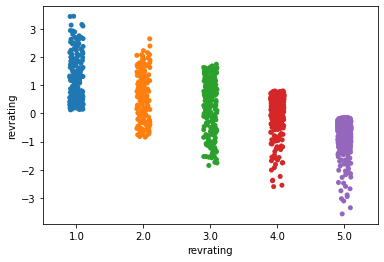

In [63]:
from sklearn.metrics import mean_absolute_error
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.2_soft','t1s_0.2_soft','t2s_0.2_soft','t3s_0.2_soft','t4s_0.2_soft']

model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,
                              max_features = 'sqrt',oob_score=True).fit(X_train[wholerevfeat],y_train)

toplot = pd.DataFrame([i for i in zip(X_train[wholerevfeat].columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(50))

ypred = model.predict(X_test[wholerevfeat])
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)

Features derived from thresholding at 0.2 and assigning sentiment in a soft way (proportional to topic importance), do a decent job of predicted review rating. MAPE of 14.7% compared to an MAPE of 14.5% when using all features.  This is also slightly better than the MAPE of 15% achieved when whole-review-based topic sentiments are used.  So just because whole-review-sentiments had a much higher topic importance in the random forest model using all features, doesn't mean whole-review-sentiments are better predictors in a smaller random forest model.

Now I repeat the same analysis using sentence derived sentiments with a threshold of 0.4 and soft thresholding

In [64]:
#Random forest only on whole review topic importance, whole review sentiment (no sentence derived sentiment score)
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.4_soft','t1s_0.4_soft','t2s_0.4_soft','t3s_0.4_soft','t4s_0.4_soft']
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train[wholerevfeat],y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)

OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.45695659731660276]
[100, 1, 'sqrt', 0.34071804102132175]
[100, 10, 'auto', 0.5841229162725304]
[100, 10, 'sqrt', 0.5888054241067542]
[100, 20, 'auto', 0.5765030487189451]
[100, 20, 'sqrt', 0.5907337290518879]
[100, 30, 'auto', 0.5813796874099784]
[100, 30, 'sqrt', 0.5864205703109713]
[200, 1, 'auto', 0.45562908230699695]
[200, 1, 'sqrt', 0.336321331561504]
[200, 10, 'auto', 0.5917428282327817]
[200, 10, 'sqrt', 0.5970149605335289]
[200, 20, 'auto', 0.5808339134484097]
[200, 20, 'sqrt', 0.5896320441708057]
[200, 30, 'auto', 0.5862576605776539]
[200, 30, 'sqrt', 0.5934789853816604]
[500, 1, 'auto', 0.45591479071815577]
[500, 1, 'sqrt', 0.33925952082642485]
[500, 10, 'auto', 0.5916693530472867]
[500, 10, 'sqrt', 0.597692322385642]
[500, 20, 'auto', 0.5866020468755602]
[500, 20, 'sqrt', 0.5934901800350294]
[500, 30, 'auto', 0.5856410712635974]
[500, 30, 'sqrt', 0.5946245312430135]


         feature  importance
5             vs    0.410978
9   t2s_0.4_soft    0.161336
2             t2    0.080955
7   t0s_0.4_soft    0.077976
6      reviewlen    0.051254
8   t1s_0.4_soft    0.042217
0             t0    0.035646
1             t1    0.031904
11  t4s_0.4_soft    0.029505
10  t3s_0.4_soft    0.028793
3             t3    0.025729
4             t4    0.023706
0.736619997909602
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14732399958192038


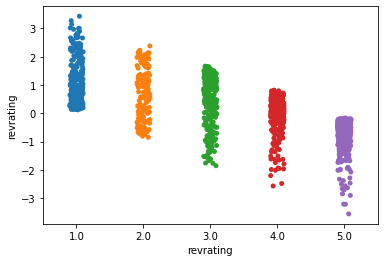

In [65]:
from sklearn.metrics import mean_absolute_error
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.4_soft','t1s_0.4_soft','t2s_0.4_soft','t3s_0.4_soft','t4s_0.4_soft']

model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,
                              max_features = 'sqrt',oob_score=True).fit(X_train[wholerevfeat],y_train)

toplot = pd.DataFrame([i for i in zip(X_train[wholerevfeat].columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(50))

ypred = model.predict(X_test[wholerevfeat])
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)

Repeating the analysis for sentence specific topic sentiments, topic threshold of 0.6 and soft assignment of sentiment

In [66]:
#Random forest only on whole review topic importance, whole review sentiment (no sentence derived sentiment score)
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.6_soft','t1s_0.6_soft','t2s_0.6_soft','t3s_0.6_soft','t4s_0.6_soft']
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train[wholerevfeat],y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)

OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.45736104180908166]
[100, 1, 'sqrt', 0.2645350262493107]
[100, 10, 'auto', 0.5859023235262684]
[100, 10, 'sqrt', 0.584236186466804]
[100, 20, 'auto', 0.5715170798935054]
[100, 20, 'sqrt', 0.5771364489342332]
[100, 30, 'auto', 0.5723196115148195]
[100, 30, 'sqrt', 0.5783224242374831]
[200, 1, 'auto', 0.45788729443749754]
[200, 1, 'sqrt', 0.2868684075166612]
[200, 10, 'auto', 0.5904507297834021]
[200, 10, 'sqrt', 0.5899563229774122]
[200, 20, 'auto', 0.5810272071796462]
[200, 20, 'sqrt', 0.5870574654467389]
[200, 30, 'auto', 0.5797354688523135]
[200, 30, 'sqrt', 0.5882931258021061]
[500, 1, 'auto', 0.4563033898123957]
[500, 1, 'sqrt', 0.30115598623334006]
[500, 10, 'auto', 0.5892248328178961]
[500, 10, 'sqrt', 0.5919692209404053]
[500, 20, 'auto', 0.5838805255688087]
[500, 20, 'sqrt', 0.5917928903863017]
[500, 30, 'auto', 0.5826153034995794]
[500, 30, 'sqrt', 0.5903561430140796]


         feature  importance
5             vs    0.512443
9   t2s_0.6_soft    0.117211
2             t2    0.100117
6      reviewlen    0.056152
0             t0    0.042913
7   t0s_0.6_soft    0.040315
1             t1    0.035349
3             t3    0.030216
4             t4    0.026655
8   t1s_0.6_soft    0.016864
10  t3s_0.6_soft    0.014071
11  t4s_0.6_soft    0.007695
0.7491720445007284
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14983440890014568


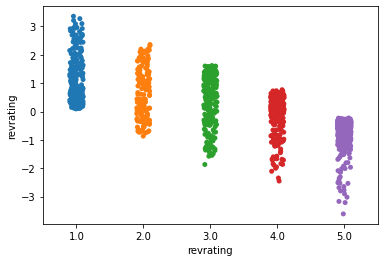

In [67]:
from sklearn.metrics import mean_absolute_error
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.6_soft','t1s_0.6_soft','t2s_0.6_soft','t3s_0.6_soft','t4s_0.6_soft']

model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,
                              max_features = 'sqrt',oob_score=True).fit(X_train[wholerevfeat],y_train)

toplot = pd.DataFrame([i for i in zip(X_train[wholerevfeat].columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(50))

ypred = model.predict(X_test[wholerevfeat])
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)

It looks like increasing the threshold the threshold above 0.2 decreases the performance of the random forest regressor.  What about assigning all sentiment to topics with importance greater than the threshold?

In [68]:
#Random forest only on whole review topic importance, whole review sentiment (no sentence derived sentiment score)
from sklearn.ensemble import RandomForestRegressor

n_estimators = [100,200,500]
max_depths = [1,10,20,30]
max_features = ['auto','sqrt']

results = []
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.4_hard','t1s_0.4_hard','t2s_0.4_hard','t3s_0.4_hard','t4s_0.4_hard']
for n_est in n_estimators:
    for max_d in max_depths:
        for max_f in max_features:
            model = RandomForestRegressor(criterion = "mse",max_depth = max_d,n_estimators = n_est,max_features = max_f,oob_score=True).fit(X_train[wholerevfeat],y_train)
            result = [n_est,max_d,max_f,model.oob_score_]
            results.append(result)
            
resultdf = pd.DataFrame(results)
resultdf.columns = ['n_estimators','max_depth','max_features','oob_score']
print('OOB scores (R2 on the holdout observations)')
for entry in results:
    print(entry)

OOB scores (R2 on the holdout observations)
[100, 1, 'auto', 0.4556073094174232]
[100, 1, 'sqrt', 0.33575046036664813]
[100, 10, 'auto', 0.5872543429615018]
[100, 10, 'sqrt', 0.5912773862435579]
[100, 20, 'auto', 0.573930305327257]
[100, 20, 'sqrt', 0.5798210620359525]
[100, 30, 'auto', 0.5751202065677252]
[100, 30, 'sqrt', 0.5788294976289741]
[200, 1, 'auto', 0.45684371652252287]
[200, 1, 'sqrt', 0.3535477985286427]
[200, 10, 'auto', 0.5882905369403928]
[200, 10, 'sqrt', 0.5949857683136983]
[200, 20, 'auto', 0.5782678668264309]
[200, 20, 'sqrt', 0.588150694756822]
[200, 30, 'auto', 0.5812168398233213]
[200, 30, 'sqrt', 0.5897921843389224]
[500, 1, 'auto', 0.4565544581673455]
[500, 1, 'sqrt', 0.3431289055567226]
[500, 10, 'auto', 0.5911143246475495]
[500, 10, 'sqrt', 0.596120106304235]
[500, 20, 'auto', 0.5822417464509365]
[500, 20, 'sqrt', 0.592411558502757]
[500, 30, 'auto', 0.584629961433279]
[500, 30, 'sqrt', 0.5900662603076976]


         feature  importance
5             vs    0.414455
9   t2s_0.4_hard    0.158380
2             t2    0.082505
7   t0s_0.4_hard    0.074890
6      reviewlen    0.051407
8   t1s_0.4_hard    0.042764
0             t0    0.036194
1             t1    0.032011
11  t4s_0.4_hard    0.030162
10  t3s_0.4_hard    0.027452
3             t3    0.025667
4             t4    0.024112
0.7366756636702826
Mean Percent Test Error in Review Rating Prediction,
Sentence Based Sentiment
0.14733513273405652


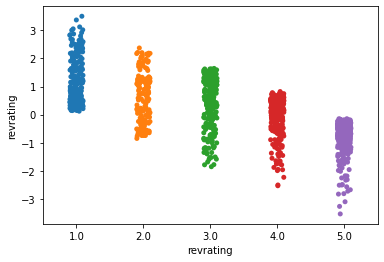

In [69]:
from sklearn.metrics import mean_absolute_error
wholerevfeat = ['t0','t1','t2','t3','t4','vs','reviewlen','t0s_0.4_hard','t1s_0.4_hard','t2s_0.4_hard','t3s_0.4_hard','t4s_0.4_hard']

model = RandomForestRegressor(criterion = "mse",max_depth = 10,n_estimators = 10000,
                              max_features = 'sqrt',oob_score=True).fit(X_train[wholerevfeat],y_train)

toplot = pd.DataFrame([i for i in zip(X_train[wholerevfeat].columns,model.feature_importances_)])
toplot.columns = ['feature','importance']
toplot.sort_values(by=['importance'],ascending=False,inplace=True)
print(toplot.head(50))

ypred = model.predict(X_test[wholerevfeat])
sns.stripplot(y_test,ypred-y_test)

print(mean_absolute_error(ypred,y_test))
print('Mean Percent Test Error in Review Rating Prediction,\nSentence Based Sentiment')
print(mean_absolute_error(ypred,y_test)/5)

This performs similarly to the sentence based sentiment assignment with threshold 0.2, and soft assignment of sentiment to different topics (14.7 MAPE vs 14.4 MAPE). Will still go ahead and assign sentence sentiment proportionally to topic importances.